# Импортирование данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from folium.plugins import HeatMap

df=pd.read_csv('/content/drive/MyDrive/курсовая 4/cpc.csv')

# Обработка датасета (работа с пропусками)

Разделение даты на временные промежутки:

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Hour'] = df['Date'].dt.hour

Заполнение пропусков модой (для категориальных данных) или средним/медианным значением (для числовых данных):

In [ ]:
df['Location Description'].fillna(df['Location Description'].mode()[0],inplace=True)
df['Latitude'].fillna(df['Latitude'].mean(),inplace=True)
df['Longitude'].fillna(df['Longitude'].mean(),inplace=True)
df['Ward'].fillna(df['Ward'].mean(),inplace=True)
df['X Coordinate'].fillna(df['X Coordinate'].mean(),inplace=True)
df['Y Coordinate'].fillna(df['Y Coordinate'].mean(),inplace=True)

<ipython-input-15-1130934645>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Location Description'].fillna(df['Location Description'].mode()[0],inplace=True)
<ipython-input-15-1130934645>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [ ]:
def set_daytime(hour):
  if 23 <= hour or hour < 5:
    return 'Night'
  elif 5 <= hour < 12:
    return 'Morning'
  elif 12 <= hour < 17:
    return 'Afternoon'
  else:
    return 'Evening'

df['Time_of_Day'] = df['Hour'].apply(set_daytime)

# Построение матрицы корреляций для числовых переменных

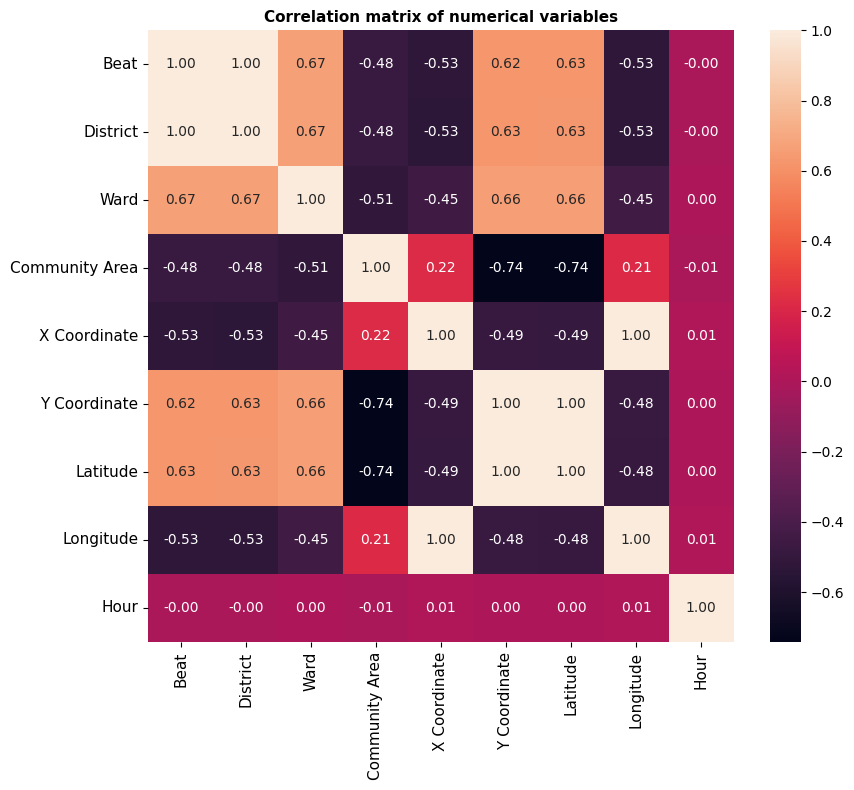

In [ ]:
plt.figure(figsize=(9,8))
sns.heatmap(df.drop(columns=['ID', 'Arrest', 'Year', 'Domestic','Date','Day_of_Week','Month','Day']).corr(numeric_only = True), annot=True, fmt='.2f')
plt.title('Correlation matrix of numerical variables', fontsize=11,fontweight='bold')
plt.tick_params(labelsize=11)
plt.tight_layout()
plt.show()

Переменные Beat, District и Ward  имеют положительную корреляцию между собой (от 0.67 до 1). Почему же это так? Скорее всего преступления определенных типов совершаются в конкретных районах местности, за что и отвечают эти три переменные. Координаты по X и Y полностью коррелируют с широтой и долготой, что правда, ведь по сути они одно и то же. В приниципе, мы можем избавиться от колонок с широтой и долготой, для построения карты будем пользоваться переменными X Coordinate, Y Coordinate.

# ML

In [ ]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Year,Updated On,Latitude,Longitude,Location,Month,Day,Day_of_Week,Hour,Time_of_Day
0,12592454,JF113025,2022-01-14 15:55:00,067XX S MORGAN ST,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,...,2022,9/14/2023 15:41,41.771782,-87.649437,"(41.771782439, -87.649436929)",1,14,4,15,Afternoon
1,12785595,JF346553,2022-08-05 21:00:00,072XX S UNIVERSITY AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,True,False,...,2022,9/14/2023 15:41,41.763338,-87.597001,"(41.763337967, -87.597001131)",8,5,4,21,Evening
2,12808281,JF373517,2022-08-14 14:00:00,055XX W ARDMORE AVE,1562,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,2022,9/14/2023 15:41,41.985875,-87.766404,"(41.985875279, -87.766403857)",8,14,6,14,Afternoon
3,12888104,JF469015,2022-11-10 03:47:00,072XX S MAY ST,1477,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,STREET,False,False,...,2022,9/14/2023 15:41,41.762615,-87.652840,"(41.76261474, -87.652840463)",11,10,3,3,Night
4,13209277,JG422539,2022-08-15 09:00:00,0000X W JACKSON BLVD,810,THEFT,OVER $500,COMMERCIAL / BUSINESS OFFICE,False,False,...,2022,9/14/2023 15:43,41.845612,-87.668599,NaN,8,15,0,9,Morning


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239558 entries, 0 to 239557
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    239558 non-null  int64         
 1   Case Number           239558 non-null  object        
 2   Date                  239558 non-null  datetime64[ns]
 3   Block                 239558 non-null  object        
 4   IUCR                  239558 non-null  object        
 5   Primary Type          239558 non-null  object        
 6   Description           239558 non-null  object        
 7   Location Description  239558 non-null  object        
 8   Arrest                239558 non-null  bool          
 9   Domestic              239558 non-null  bool          
 10  Beat                  239558 non-null  int64         
 11  District              239558 non-null  int64         
 12  Ward                  239558 non-null  float64       
 13 

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report, roc_curve, roc_auc_score

columns = df[['Case Number','FBI Code','Updated On','Location','IUCR','Domestic','Description','Primary Type','Location Description','Block','Date']]
encoders={}
for col in columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    encoders[col] = encoder
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Year,Updated On,Latitude,Longitude,Location,Month,Day,Day_of_Week,Hour,Time_of_Day
0,12592454,5697,3403,22436,167,22,129,102,False,1,...,2022,1322,41.771782,-87.649437,33140,1,14,4,15,Afternoon
1,12785595,131108,65425,23282,85,27,229,17,True,0,...,2022,1322,41.763338,-87.597001,28626,8,5,4,21,Evening
2,12808281,146674,68276,19518,87,27,13,102,False,0,...,2022,1322,41.985875,-87.766404,112308,8,14,6,14,Afternoon
3,12888104,201297,96647,23245,69,30,216,119,False,0,...,2022,1322,41.762615,-87.652840,28251,11,10,3,3,Night
4,13209277,238767,68505,449,284,29,183,45,False,0,...,2022,1323,41.845612,-87.668599,118347,8,15,0,9,Morning


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239558 entries, 0 to 239557
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    239558 non-null  int64  
 1   Case Number           239558 non-null  int64  
 2   Date                  239558 non-null  int64  
 3   Block                 239558 non-null  int64  
 4   IUCR                  239558 non-null  int64  
 5   Primary Type          239558 non-null  int64  
 6   Description           239558 non-null  int64  
 7   Location Description  239558 non-null  int64  
 8   Arrest                239558 non-null  bool   
 9   Domestic              239558 non-null  int64  
 10  Beat                  239558 non-null  int64  
 11  District              239558 non-null  int64  
 12  Ward                  239558 non-null  float64
 13  Community Area        239558 non-null  int64  
 14  FBI Code              239558 non-null  int64  
 15  

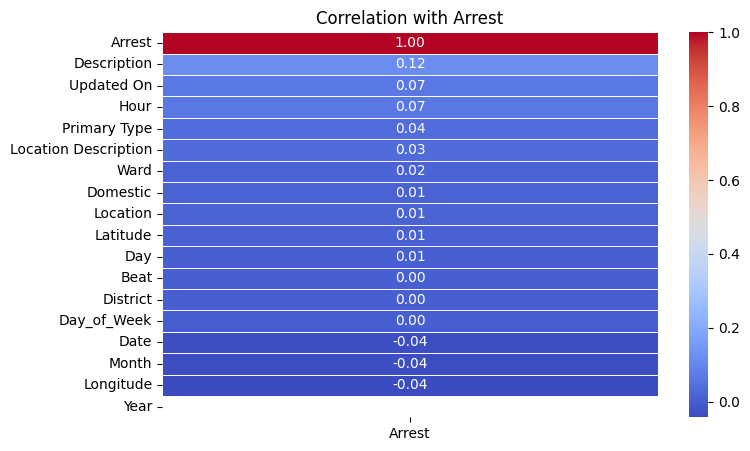

In [ ]:
correlation_matrix = df.drop(columns=['Case Number','Y Coordinate','X Coordinate','Y Coordinate','IUCR','ID','Community Area','FBI Code','Block']).corr(numeric_only=True)
correlation_arrest = correlation_matrix['Arrest'].sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_arrest.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation with Arrest')
plt.show()

In [ ]:
X = df[['Description','Updated On','Hour','Primary Type','Location Description','Ward','Domestic']]
y = df['Arrest']
X

,Description,Updated On,Hour,Primary Type,Location Description,Ward,Domestic
0,129,1322,15,22,102,16.0,1
1,229,1322,21,27,17,5.0,0
2,13,1322,14,27,102,39.0,0
3,216,1322,3,30,119,17.0,0
4,183,1323,9,29,45,4.0,0
...,...,...,...,...,...,...,...
239553,116,383,10,10,99,48.0,0
239554,116,1340,23,10,119,25.0,0
239555,116,1340,16,10,21,9.0,0
239556,116,1298,2,10,119,22.0,0


In [ ]:
X_train, X_test, y_train, y_test =train_test_split(X, y, random_state = 42, test_size= 0.2)

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

log_reg = LogisticRegression(max_iter=1000, C=100)
log_reg.fit(X_train_sc,y_train)

y_pred = log_reg.predict(X_test_sc)
y_pred_proba = log_reg.predict_proba(X_test_sc)[:,1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", acc)
print("AUC:",auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8818876273167474
AUC: 0.6485321976051153

Classification Report:
               precision    recall  f1-score   support

       False       0.88      1.00      0.94     42269
        True       0.21      0.00      0.00      5643

    accuracy                           0.88     47912
   macro avg       0.55      0.50      0.47     47912
weighted avg       0.80      0.88      0.83     47912



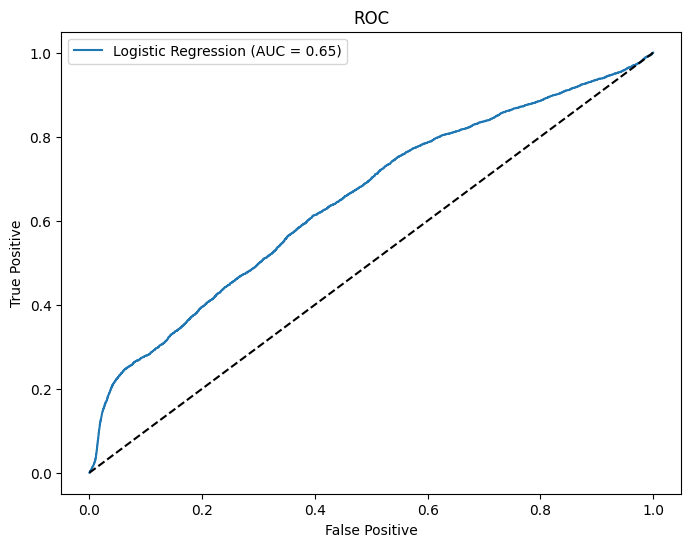

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC')
plt.legend()
plt.show()

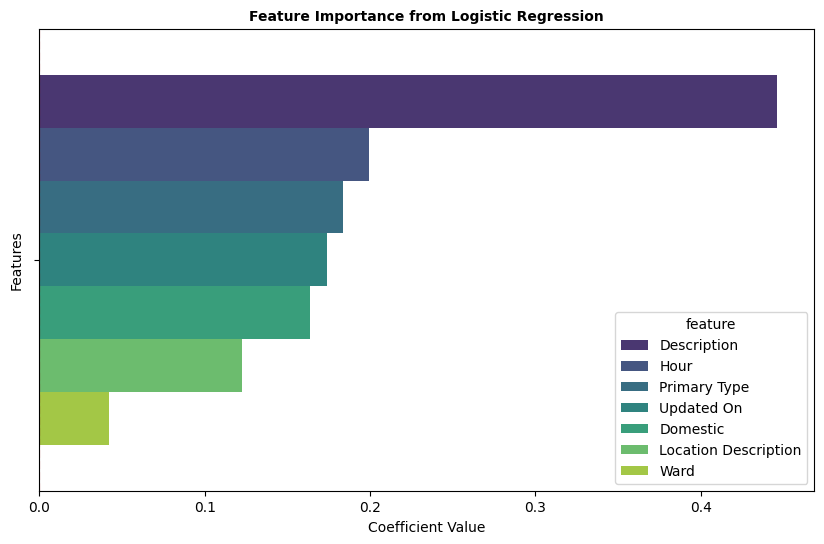

,feature,importance
0,Description,0.446381
1,Hour,0.199434
2,Primary Type,0.183754
3,Updated On,0.173892
4,Domestic,0.163558
5,Location Description,0.122712
6,Ward,0.042228


In [ ]:
feature_importances = pd.DataFrame({'feature': X.columns,'importance': log_reg.coef_[0]}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', hue='feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance from Logistic Regression',fontweight='bold',fontsize='medium')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.axvline(0, color='red', linestyle='--')
plt.show()

display(feature_importances.reset_index(drop=True))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train_sc, y_train)

y_pred_rf = rf.predict(X_test_sc)
y_proba_rf = rf.predict_proba(X_test_sc)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy: 0.8221113708465521
AUC: 0.8876301495522251

Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.83      0.89     42269
        True       0.38      0.78      0.51      5643

    accuracy                           0.82     47912
   macro avg       0.67      0.80      0.70     47912
weighted avg       0.90      0.82      0.85     47912

